In [2]:
import diffrax as dfx
import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib as mpl
import matplotlib.pyplot as plt

from felice.neuron_models import FHNRS

In [23]:
key = jrand.key(0)
max_time = 200

neuron_model = FHNRS(
    gmax_pasive=2.0,
    Erev_pasive=0.0,
    a_fast=-2.0,
    voff_fast=0.0,
    tau_fast=0.0,
    a_slow=0.5,
    voff_slow=1.0,
    tau_slow=50.0,
    vthr=jnp.inf,
)


def state_at_t(comp_times):
    sol = dfx.diffeqsolve(
        terms=dfx.ODETerm(neuron_model.dynamics),
        solver=dfx.Tsit5(),
        t0=0.0,
        t1=max_time,
        dt0=1e-3,
        y0=neuron_model.init_state(1)
        + jrand.uniform(key, shape=(1, 3), minval=0.1, maxval=0.5),
        saveat=dfx.SaveAt(ts=comp_times),
        max_steps=200000,
    )

    return sol.ts, sol.ys

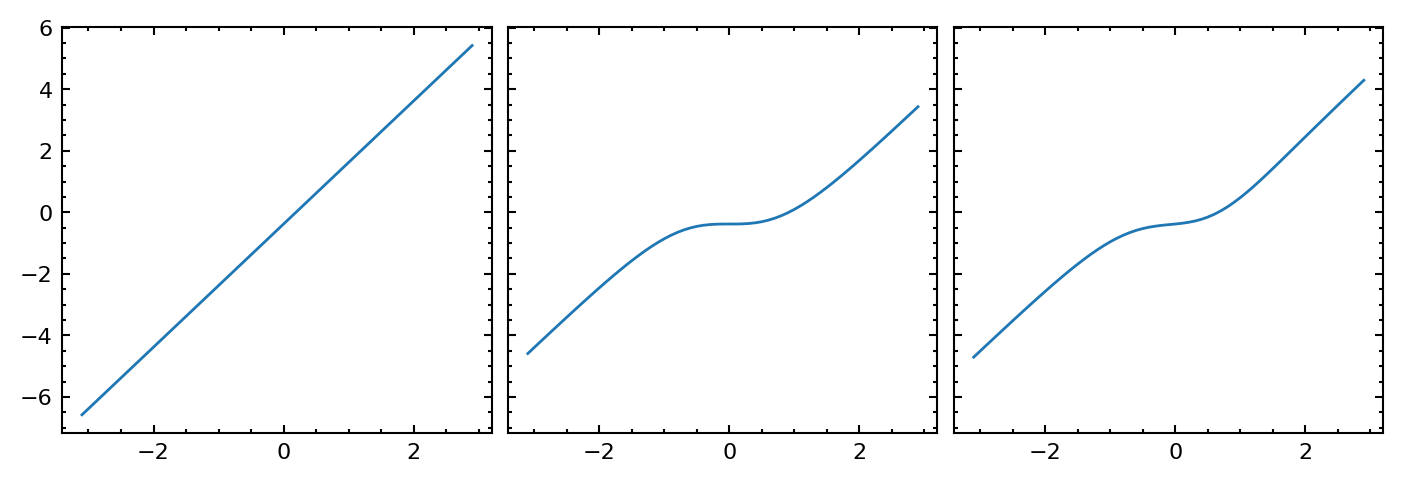

In [24]:
v_range = jnp.arange(-3.1, 3, 0.1)
VI_inst = jax.vmap(neuron_model.IV_inst)(v_range)
VI_fast = jax.vmap(neuron_model.IV_fast)(v_range)
VI_slow = jax.vmap(neuron_model.IV_slow)(v_range)

with mpl.style.context("boilerplot.ieeetran"):
    fig, ax = plt.subplots(1, 3, figsize=(6.9, 2.3), dpi=200.0, sharey=True)
    ax[0].plot(v_range, VI_inst)
    ax[1].plot(v_range, VI_fast)
    ax[2].plot(v_range, VI_slow)
    plt.show()

In [25]:
comp_times = jnp.linspace(0.0, max_time, 500)
_, state = state_at_t(comp_times)

In [26]:
def compute_nullclines(neuron_model, u_range, v_range, resolution=200):
    """
    Compute nullclines
    du/dt = 0 (u-nullcline)
    dv/dt = 0 (v-nullcline)
    """
    u_vals = jnp.linspace(u_range[0], u_range[1], resolution)
    v_vals = jnp.linspace(v_range[0], v_range[1], resolution)
    U, V = jnp.meshgrid(u_vals, v_vals)

    UV = jnp.stack(
        [U.reshape(-1), V.reshape(-1), jnp.zeros((resolution * resolution,))], axis=1
    )
    dS = neuron_model.dynamics(0, UV, {})
    dU = dS[:, 0].reshape(U.shape)
    dV = dS[:, 1].reshape(V.shape)

    return U, V, dU, dV


def plot_vf(ax, neuron_model, u_range, v_range):
    import numpy as np

    u_sparse = jnp.linspace(u_range[0], u_range[1], 30)
    v_sparse = jnp.linspace(v_range[0], v_range[1], 30)

    Us, Vs = jnp.meshgrid(u_sparse, v_sparse)

    U, V, dU, dV = compute_nullclines(neuron_model, u_range, v_range, 200)

    UVs = jnp.stack([Us.reshape(-1), Vs.reshape(-1), jnp.ones((30 * 30,))], axis=1)
    dS = neuron_model.dynamics(0, UVs, {})
    dUs = dS[:, 0].reshape(Us.shape)
    dVs = dS[:, 1].reshape(Vs.shape)

    # Normalize for visualization
    magnitude = np.sqrt(dUs**2 + dVs**2)
    magnitude[magnitude == 0] = 1
    dUs_norm = dUs / magnitude
    dVs_norm = dVs / magnitude

    # Nullclines
    ax.contour(U, V, dU, levels=[0], colors="blue", linewidths=1, linestyles="-")
    ax.contour(U, V, dV, levels=[0], colors="red", linewidths=1, linestyles="-")

    # Vector field
    ax.quiver(Us, Vs, dUs_norm, dVs_norm, magnitude, cmap="viridis", alpha=0.6)

    ax.set_xlabel("v")
    ax.set_ylabel("w")
    ax.legend(["u-nullcline (du/dt=0)", "v-nullcline (dv/dt=0)"], loc="upper right")
    ax.set_xlim(u_range)
    ax.set_ylim(v_range)
    ax.axhline(y=0, color="gray", linestyle="--", alpha=0.3)
    ax.axvline(x=0, color="gray", linestyle="--", alpha=0.3)

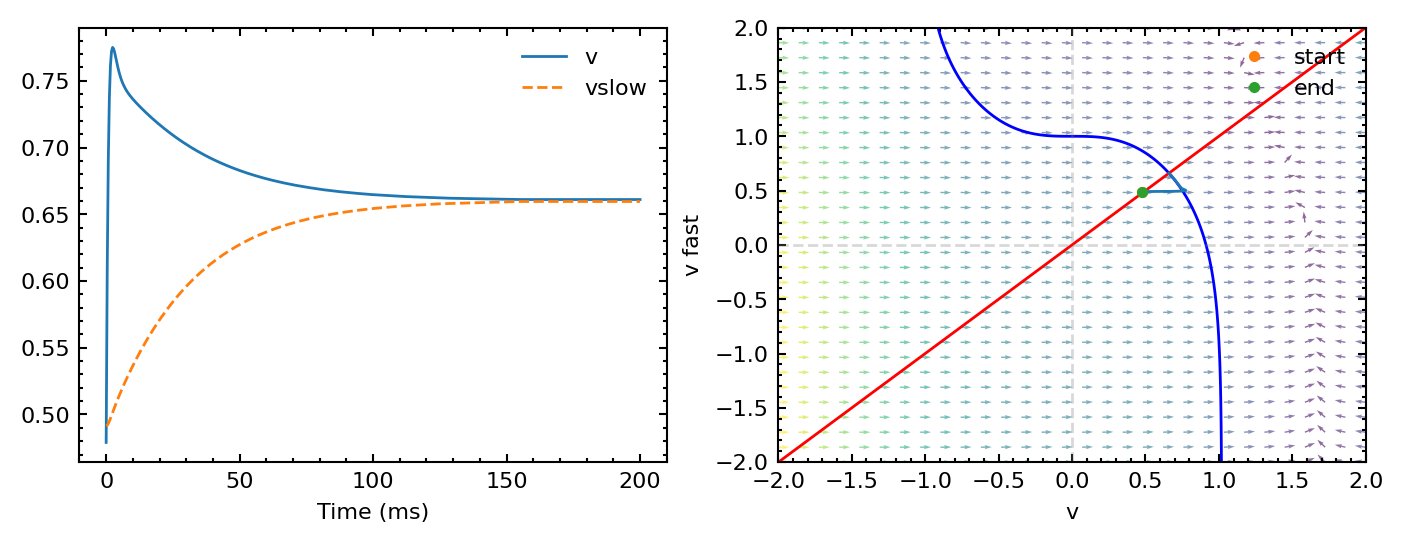

In [27]:
with mpl.style.context("boilerplot.ieeetran"):
    fig, ax = plt.subplots(1, 2, figsize=(6.9, 2.6), dpi=200)
    ax[0].plot(comp_times, state[:, 0, 0])
    ax[0].plot(comp_times, state[:, 0, 1], "--")
    # ax[0].plot(comp_times, state[0, :, 2], "-.")
    ax[0].set_xlabel("Time (ms)")
    ax[0].legend(["v", "vslow", "syn"])

    plot_vf(ax[1], neuron_model, [-2, 2], [-2, 2])

    ax[1].plot(state[:, 0, 0], state[:, 0, 1])
    ax[1].plot(state[0, 0, 0], state[0, 0, 1], ".", label="start")
    ax[1].plot(state[0, -1, 0], state[0, -1, 1], ".", label="end")
    ax[1].set_xlabel("v")
    ax[1].set_ylabel("v fast")
    ax[1].legend()
    plt.show()